### Examine the Data

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


# Read the dataset
df_raw = pd.read_csv('waterTank_valueFlip_ctrl.csv', index_col=0, header=0, parse_dates=True)
df_raw.index.freq = 'MS'

df_raw.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [74]:
df_raw.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

### Plot the source data

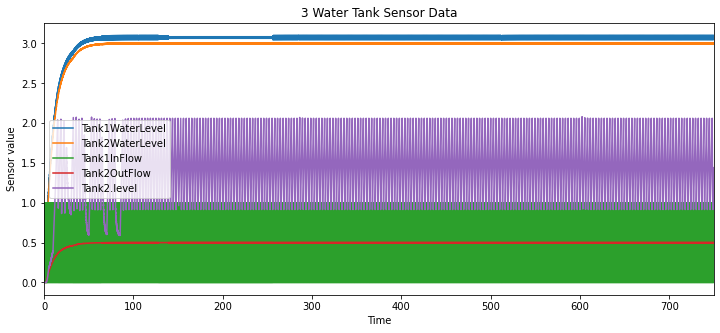

In [75]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df_raw['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df_raw['Tank2WaterLevel'].plot(legend=True)
df_raw['Tank1InFlow'].plot(legend=True)
df_raw['Tank2OutFlow'].plot(legend=True)

df_raw['Tank2.level'].plot(legend=True)
plt.show()

In [76]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [77]:
adf_test(df_raw['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.325979e+01
p-value                 8.443583e-25
#lags                   4.200000e+01
#observations           1.495800e+04
critical value (1%)    -3.430787e+00
critical value (5%)    -2.861733e+00
critical value (10%)   -2.566873e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [78]:
# All the correlated features are stationary.
df_raw.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


### Normalisation of the dataset

In [79]:
# def normalise_timeseries(data):
#     # Calculate the mean and standard deviation for each feature
#     means = np.mean(data, axis=0)
#     stds = np.std(data, axis=0)
    
#     # Normalise each feature using standard deviation
#     normalised_data = (data - means) / stds
    
#     return pd.DataFrame(normalised_data), means, stds

In [80]:
# Read the mean and std used for normalising the golden model
var_df = pd.read_csv("norm_var.csv", index_col=0)
old_means, old_stds = var_df["0"], var_df["1"]

def normalise_series(data, means, stds):
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)


def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


normalised_data = normalise_series(df_raw, old_means, old_stds)

In [81]:
df = normalised_data

In [82]:
df

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.10,-13.736104,-13.647793,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.15,-13.504895,-13.607095,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
...,...,...,...,...,...,...,...
749.80,0.227724,0.167719,-1.001251,0.158064,-0.58372,-0.563189,-0.304058
749.85,0.131271,0.173739,-1.001251,0.175378,-0.58372,-0.563189,-0.247394
749.90,0.025990,0.142666,-1.001251,0.157702,-0.58372,-0.563189,-0.162263


In [83]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(12001, 3000)

### VAR Model Order Selection

In [84]:
p = [1,2,3,4,5,6,7] # try with list of 7 p values
p = list(range(1,20))
aic, bic = [], []
for i in p:
    model = VAR(train)
    results = model.fit(i)
    aic.append(results.aic)
    bic.append(results.bic)
    print(f'VAR Order {i}')
    print('AIC: {}'.format(results.aic))
    print('BIC: {}'.format(results.bic))
    print()

min_aic = min(aic)
min_aic_index = aic.index(min_aic) + 1
min_bic = min(bic)
min_bic_index = bic.index(min_bic) + 1
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


VAR Order 1
AIC: -42.11268237448719
BIC: -42.07818328548626

VAR Order 2
AIC: -46.45463166311201
BIC: -46.389941209561194

VAR Order 3
AIC: -50.2129633167777
BIC: -50.11807714673063

VAR Order 4
AIC: -53.304628665830684
BIC: -53.179542426337854

VAR Order 5
AIC: -54.826463020002684
BIC: -54.67117235711114

VAR Order 6
AIC: -55.97412271546037
BIC: -55.7886232742134

VAR Order 7
AIC: -56.96740943870118
BIC: -56.75169686313799

VAR Order 8
AIC: -57.322774192042374
BIC: -57.07684412519776

VAR Order 9
AIC: -57.79591304956326
BIC: -57.51976113346732

VAR Order 10
AIC: -59.45323966908601
BIC: -59.1468615447638

VAR Order 11
AIC: -59.814214179639386
BIC: -59.47760548711063

VAR Order 12
AIC: -60.60937851832036
BIC: -60.24253489659911

VAR Order 13
AIC: -60.86636968534713
BIC: -60.469286772441464

VAR Order 14
AIC: -61.49326558936687
BIC: -61.06593902227856

VAR Order 15
AIC: -61.887609916549096
BIC: -61.430035331273324

VAR Order 16
AIC: -62.59750979038396
BIC: -62.109682821908955

VAR Order 

In [85]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

In [86]:
from IPython.display import Markdown as md
md("Fit the VAR( {{}} ) model".format(min_aic_index))

Fit the VAR( {} ) model

### Fit the VAR {{min_aic_index}}  model

In [87]:
min_aic_index

19

In [88]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, Jun, 2023
Time:                     12:47:18
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -63.9084
Nobs:                     11982.0    HQIC:                  -64.2929
Log likelihood:           268268.    FPE:                9.85475e-29
AIC:                     -64.4870    Det(Omega_mle):     9.11666e-29
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.003100         0.000199          -15.607           0.000
L1.Tank1WaterLevel          0.329067         0.010414           31.600           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [89]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

19

In [90]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.10,-13.736104,-13.647793,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.15,-13.504895,-13.607095,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034


In [91]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 0.22752998,  0.16777326, -1.00159916,  0.15810892,  1.63338667,
         1.02493759, -1.36966177],
       [ 0.09206106,  0.16721173, -1.00903841,  0.1745329 , -0.56888959,
         0.87153998, -1.49923309],
       [ 0.02635749,  0.14251356, -0.98225163,  0.15750908, -0.61566035,
        -0.55463364, -1.44837249],
       [ 0.16565628,  0.12352068,  1.00850355,  0.12636281, -0.59481932,
        -0.60088717, -1.36285177],
       [ 0.23963344,  0.14101341,  0.98944808,  0.13366127, -0.61818244,
        -0.58400035, -1.30231422],
       [ 0.17556311,  0.1746062 , -1.00397616,  0.16975355, -0.61357982,
        -0.62414189, -1.21193916],
       [ 0.09120384,  0.16703061, -1.00039238,  0.17441722, -0.59918496,
        -0.58899327, -1.15146156],
       [ 0.06900291,  0.1293887 ,  1.00008339,  0.14354913, -0.62423852,
        -0.59623354, -1.0628234 ],
       [ 0.16696155,  0.12360526,  0.99956885,  0.12634928, -0.58331394,
        -0.59579439, -1.00325927],
       [ 0.27066232,  0.1548

In [92]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
600.05,0.227723,0.167718,-1.001251,0.158063,1.713149,1.020218,-1.370958
600.10,0.092377,0.167225,-1.001251,0.174568,-0.583720,0.939788,-1.509683
600.15,0.025989,0.142665,-1.001251,0.157701,-0.583720,-0.563189,-1.465045
600.20,0.165422,0.123576,0.998751,0.126509,-0.583720,-0.563189,-1.380027
600.25,0.239055,0.140813,0.998751,0.133594,-0.583720,-0.563189,-1.323489
...,...,...,...,...,...,...,...
749.80,0.227724,0.167719,-1.001251,0.158064,-0.583720,-0.563189,-0.304058
749.85,0.131271,0.173739,-1.001251,0.175378,-0.583720,-0.563189,-0.247394
749.90,0.025990,0.142666,-1.001251,0.157702,-0.583720,-0.563189,-0.162263


In [93]:
# idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
# df_forecast = pd.DataFrame(z, index=idx, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast = pd.DataFrame(z, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,0.227530,0.167773,-1.001599,0.158109,1.633387,1.024938,-1.369662
1,0.092061,0.167212,-1.009038,0.174533,-0.568890,0.871540,-1.499233
2,0.026357,0.142514,-0.982252,0.157509,-0.615660,-0.554634,-1.448372
3,0.165656,0.123521,1.008504,0.126363,-0.594819,-0.600887,-1.362852
4,0.239633,0.141013,0.989448,0.133661,-0.618182,-0.584000,-1.302314


### Plot the results

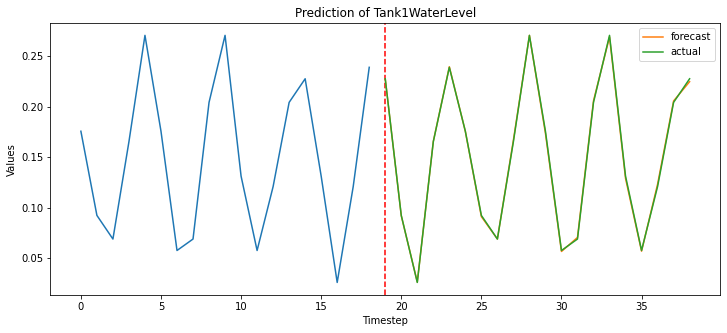

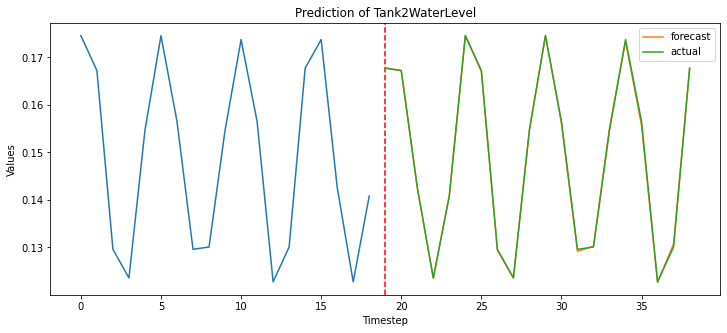

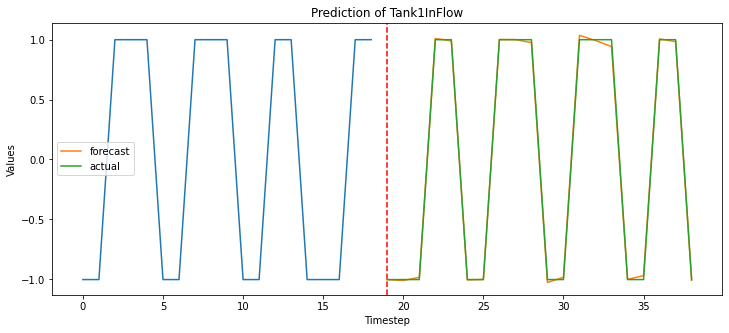

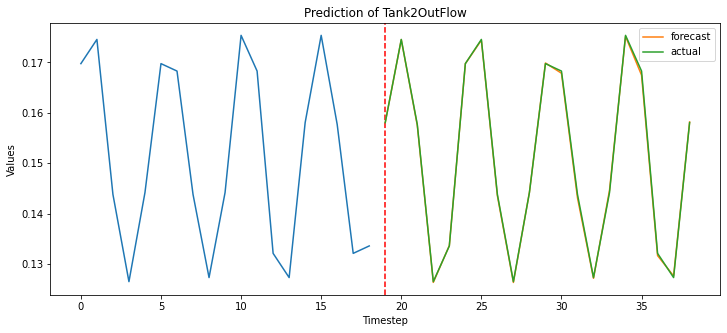

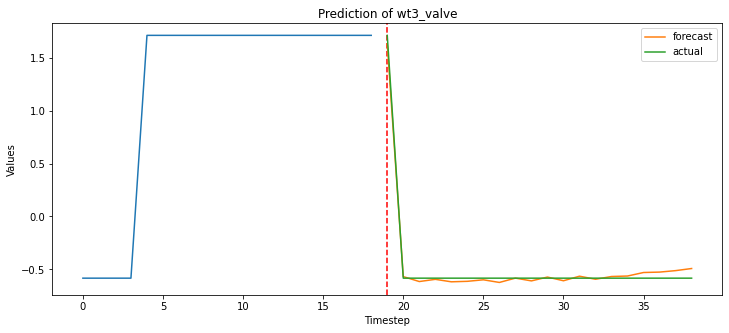

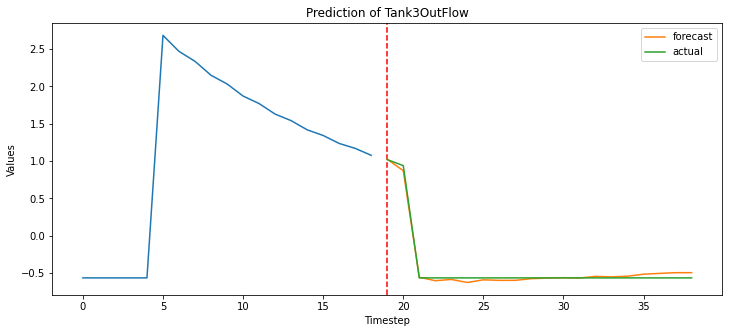

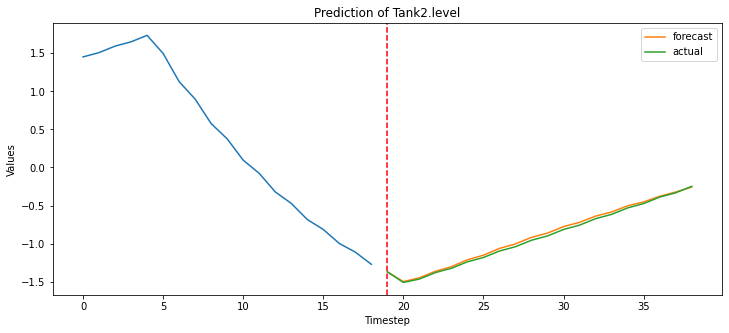

In [94]:
attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(lag_order)))
    actual = train.iloc[-lag_order:,:]
    
    index = pd.Index(list(range(lag_order, lag_order + steps)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:lag_order+1,:].set_index(index)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

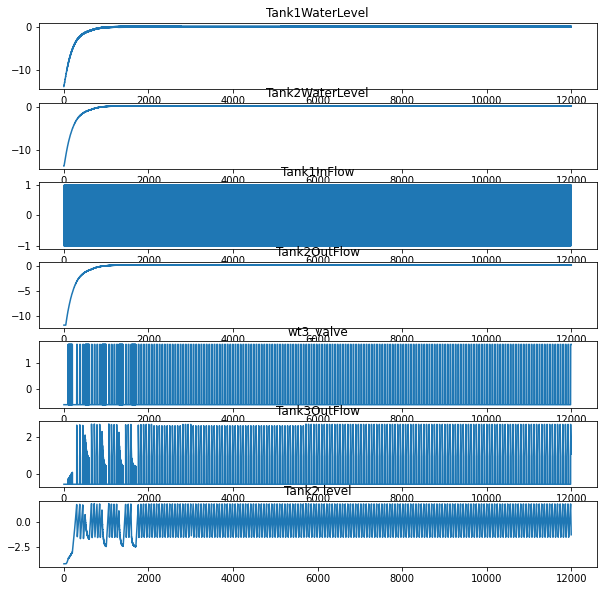

In [95]:
results.plot();

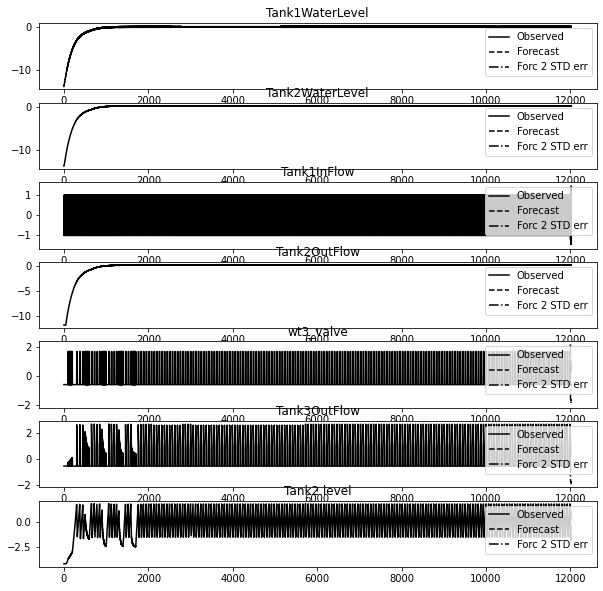

In [96]:
results.plot_forecast(20);

In [97]:
len(df_forecast)

20

In [98]:
len(df['Tank1WaterLevel'].iloc[:steps])

20

### Model Evaluation

In [99]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(pred[feat].iloc[:steps], actual_test[feat]))

print(RMSE) 

[0.001376905815856887, 0.00033726206192604807, 0.020275514798629567, 0.0003239232421834781, 0.041063790797036155, 0.038853928886736576, 0.02708284658619679]


### Save the model

In [100]:
# Serialize andsave the model
import pickle
import statsmodels.api as sm
with open('var_ctrl_valueFlip.pkl', 'wb') as f:
    pickle.dump(results.params, f)
print("Model saved!")

Model saved!


### Define the faulty data

In [101]:
faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)

faulty_data.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

(12001, 3000)

### Load the model and reconstruct VAR

In [102]:
with open('var_ctrl_valueFlip.pkl', 'rb') as f:
    params = pickle.load(f)
    
valueFlip_model = sm.tsa.VAR(train)
valueFlip_model.params = params
valueFlip_model_fit = valueFlip_model.fit(min_aic_index)

valueFlip_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, Jun, 2023
Time:                     12:47:21
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -63.9084
Nobs:                     11982.0    HQIC:                  -64.2929
Log likelihood:           268268.    FPE:                9.85475e-29
AIC:                     -64.4870    Det(Omega_mle):     9.11666e-29
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.003100         0.000199          -15.607           0.000
L1.Tank1WaterLevel          0.329067         0.010414           31.600           0.000
L1.Tank2WaterLevel        

### Forecast using faulty data

In [103]:
# Use the loaded model to make predictions or perform other analyses
forecast = valueFlip_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

array([[  2.85242462,   3.09730461,  -4.45232834,   0.63481019,
          3.94588563,   3.66744368,  25.74613383],
       [  2.73014938,   3.05812465,  -3.46611098,   0.6766    ,
          4.50707748,   7.14567635,  24.90905591],
       [  2.88974652,   2.93980079,   5.50942665,   0.65375691,
          7.0237948 ,   9.03143147,  23.77272274],
       [  3.15098777,   2.9547179 ,   4.95120698,   0.71988146,
          7.90025056,  11.81482617,  22.31106303],
       [  3.30617209,   3.1491892 ,  -5.8445299 ,   0.96935334,
         10.51338672,  13.69769841,  20.59434588],
       [  2.92640051,   3.1369025 ,  -8.21213132,   1.1076627 ,
          9.84426036,  15.6711759 ,  18.68650088],
       [  2.55226737,   2.9635871 ,  -0.88890881,   1.12140689,
         13.87155981,  16.4038975 ,  16.64796343],
       [  2.94059092,   2.92873763,   3.18523381,   1.15692596,
         12.92233858,  18.23779565,  14.42890715],
       [  3.56745331,   3.12782446,  -4.1626317 ,   1.38218037,
         16.7191

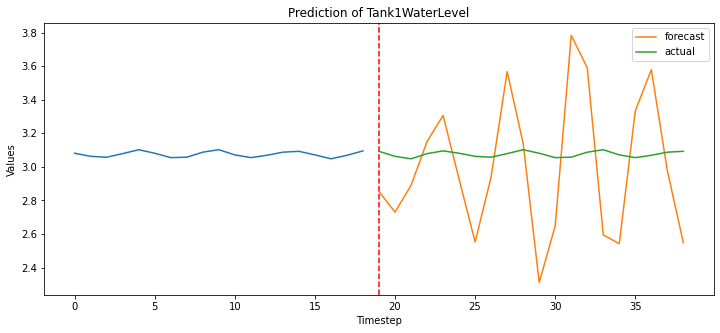

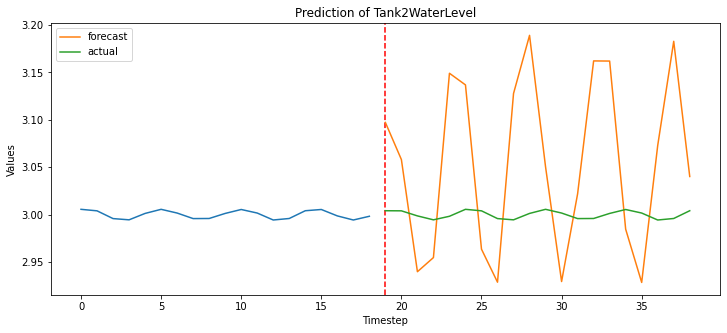

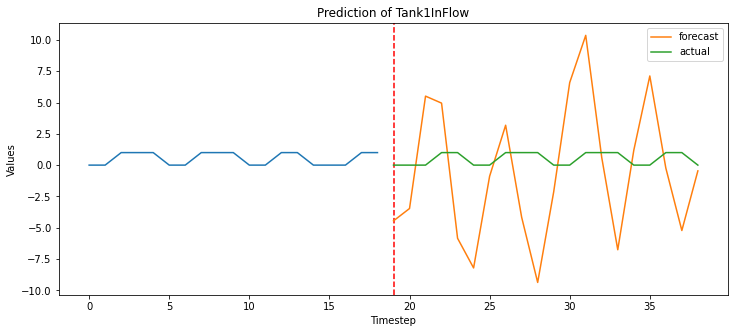

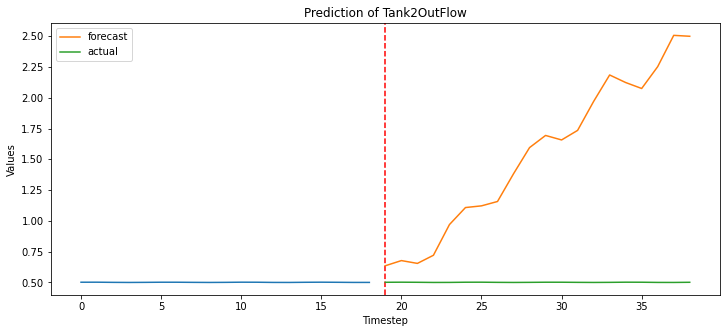

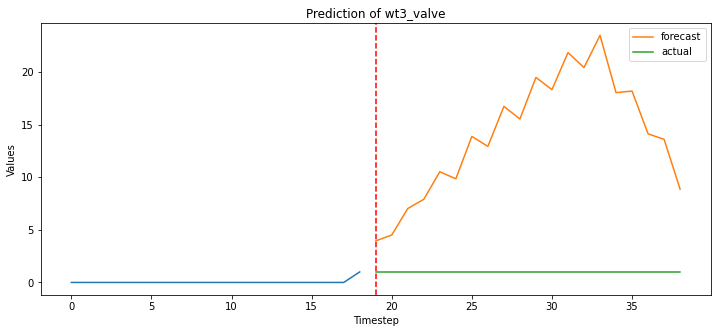

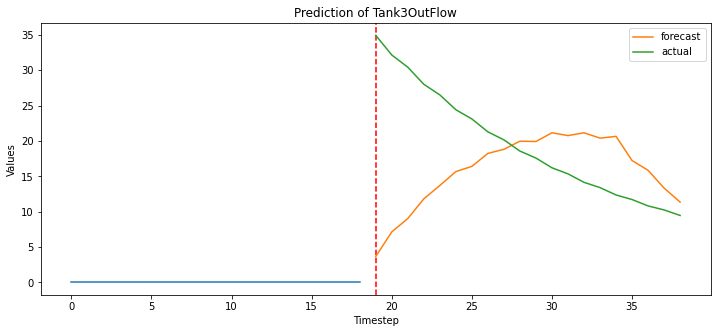

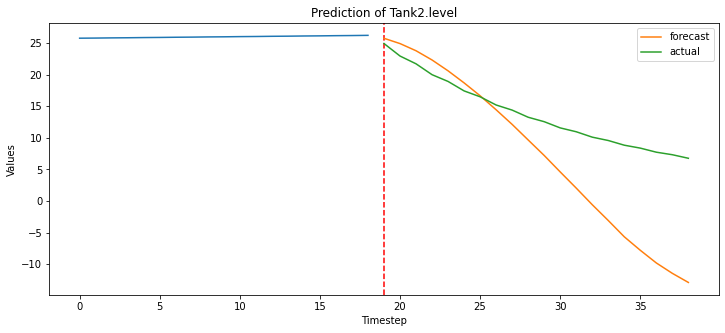

In [104]:
fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [105]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

[16.199748911737238, 16.28310049068578, 4.716744581173606, 13.268209902616213, 15.563201135851738, 17.10938404865268, 17.316588986891517]


### Increasing the duration of the faults

In [106]:
faulty_data_extend = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)

faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

(12001, 3000)

In [107]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = valueFlip_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

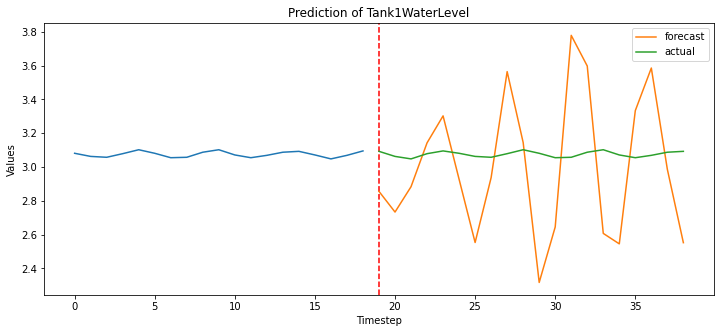

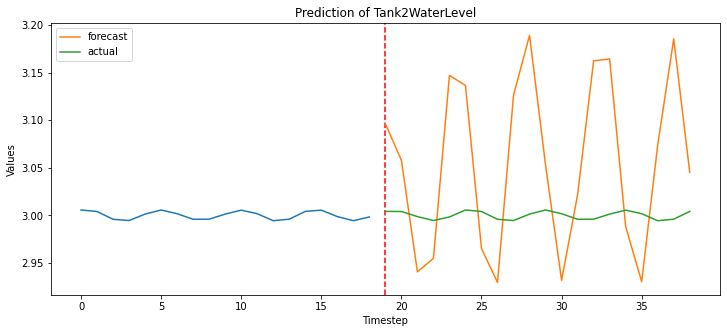

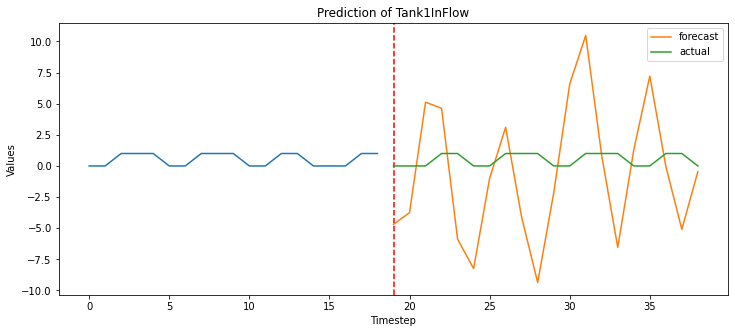

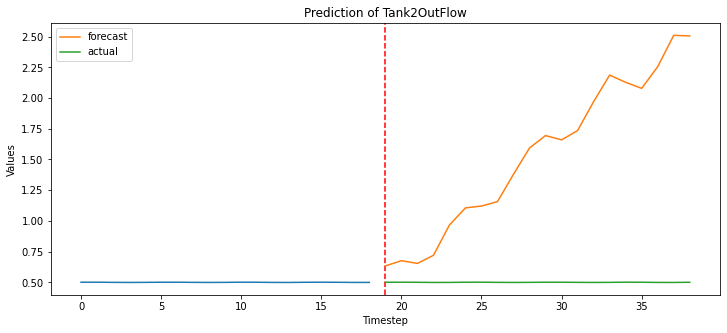

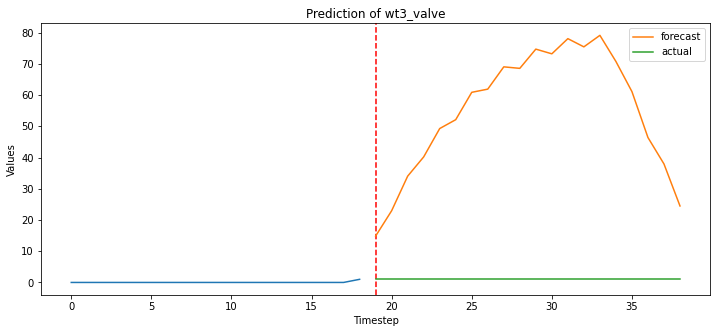

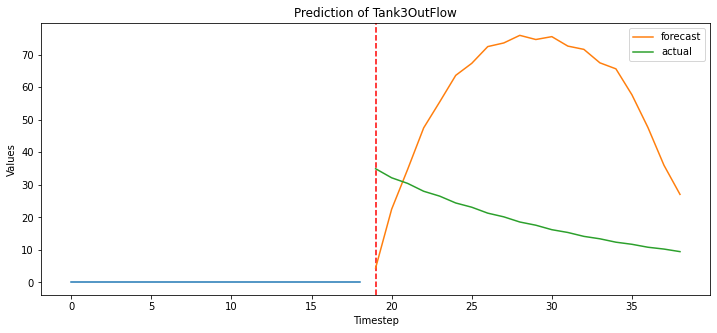

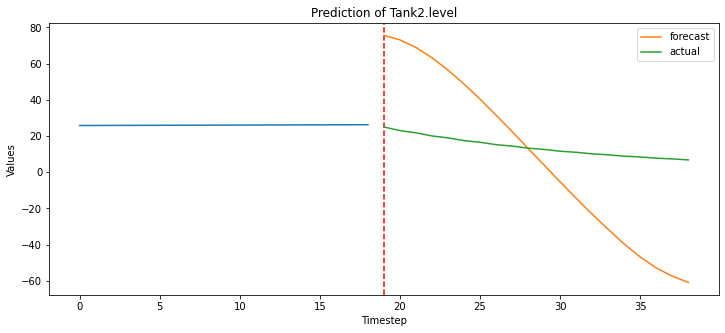

In [108]:
fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [109]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

[16.20117537492531, 16.28396418197694, 4.707496135072434, 13.269235091765207, 58.6764480967187, 59.76605435755286, 47.797139587478014]


In [110]:
import keyword
print(keyword.kwlist)

['False', 'None', 'True', 'and', 'as', 'assert', 'async', 'await', 'break', 'class', 'continue', 'def', 'del', 'elif', 'else', 'except', 'finally', 'for', 'from', 'global', 'if', 'import', 'in', 'is', 'lambda', 'nonlocal', 'not', 'or', 'pass', 'raise', 'return', 'try', 'while', 'with', 'yield']
